In [ ]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

In [2]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

In [3]:
import pystac_client
import stackstac

In [4]:
bbox = Box(ymin=23.612709, xmin=58.361626, ymax=23.556148, xmax=58.429526).normalize()
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox

Box(ymin=23.556148, xmin=58.361626, ymax=23.612709, xmax=58.429526)

In [ ]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2017-01-01/2023-12-31",
    # datetime="2022-01-01/2023-12-31",
    query={"eo:cloud_cover": {"lt": 5}},
).item_collection()
len(items)

In [143]:
stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-783a959ac54582049c80e0f414383f14' (time: 262,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(262, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-01...
    id                                       (time) <U24 'S2A_40QFM_20170101_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 2.7e+06 ... 2.59e+06
    created                                  (time) <U24 '2022-11-08T08:37:59...
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32640
Attributes:
    spec:        RasterSpec(epsg=32640, bounds=(600000.0, 2590200.0, 709800.0...
    crs:         epsg:32640
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 2700000.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [102]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir09', # B09
        'swir16', # ???
        'swir16', # B11
        'swir22', # B12
        'nir08', # B8A
    ])

### Create the `RasterSource`

In [8]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [103]:
xmin_px, ymin_px = crs_transformer.map_to_pixel((bbox.xmin, bbox.ymin))
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=xmin_px, y=ymin_px, band=[0]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-15a8136bd1bce142978ed39251d2f560' (time: 262,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(262, 13, 10980, 10980), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-01...
    id                                       (time) <U24 'S2A_40QFM_20170101_...
  * band                                     (band) <U12 'coastal' ... 'nir08'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 2.7e+06 ... 2.59e+06
    created                                  (time) <U24 '2022-11-08T08:37:59...
    ...                                       ...
    raster:bands                             (band) object None None ... None
    gsd                                      (band) object 60 10 10 ... 20 20 20
    common_name                              (band) object 'coastal' ... 'nir08'
    center_wavelength                        (band) object 0.443 0.49 ... 0.865
    full_width_half_max                      (band) object 0.027 0.098 ... 0.033
    epsg                                     int64 32640
Attributes:
    spec:        RasterSpec(epsg=32640, bounds=(600000.0, 2590200.0, 709800.0...
    crs:         epsg:32640
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 2700000.00|\n| 0.0...
    resolution:  10.0

In [82]:
# means = np.array([756.4, 889.6, 1151.7, 1307.6, 1637.6, 2212.6, 2442.0, 2538.9, 2602.9, 2666.8, 2388.8, 2388.8, 1821.5])
# stds = np.array([1111.4, 1159.1, 1188.1, 1375.2, 1376.6, 1358.6, 1418.4, 1476.4, 1439.9, 1582.1, 1460.7, 1460.7, 1352.2])
# stats = RasterStats(means, stds)
# stats.save('SSL4EO_stats.json')

In [13]:
stats_tf = StatsTransformer.from_stats_json('SSL4EO_stats.json')

In [14]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=[3, 2, 1],
    temporal=True
)
raster_source.shape

(262, 10980, 10980, 3)

In [15]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [213]:
# window = raster_source.crs_transformer.map_to_pixel(bbox).normalize()
# window.extent
window = Box(ymin=8900, xmin=4150, ymax=9150, xmax=4450)
window.extent

Box(ymin=0, xmin=0, ymax=250, xmax=300)

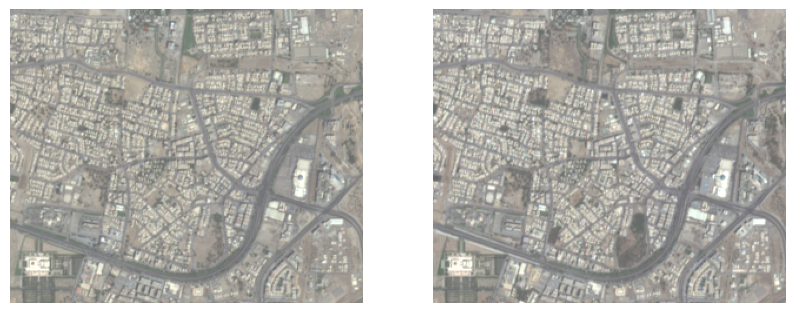

In [214]:
img1 = raster_source.get_chip(window, time=np.where(t_strs == '2019-09-18')[0].squeeze())
img2 = raster_source.get_chip(window, time=np.where(t_strs == '2023-09-12')[0].squeeze())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1)
ax2.imshow(img2)
ax1.axis('off')
ax2.axis('off')
plt.show()

---

In [105]:
stats_path_cd = 's3://raster-vision-ahassan/oscd/cd_blog/blog_4/analyze/stats/train_scenes/stats.json'
stats_tf_cd = StatsTransformer.from_stats_json(stats_path_cd)

In [106]:
stats_tf_cd.means[9] = stats_tf_cd.means[10]
stats_tf_cd.stds[9] = stats_tf_cd.stds[10]

stats_tf_cd.means[9 + 13] = stats_tf_cd.means[10 + 13]
stats_tf_cd.stds[9 + 13] = stats_tf_cd.stds[10 + 13]

In [145]:
stats_tf_cd.means[:13], stats_tf_cd.means[13:]

(array([1551.92119778, 1336.64289556, 1232.53053333, 1247.29935   ,
        1372.6935    , 1746.66172111, 1931.13684667, 1852.98324778,
         632.88502778, 1890.14376778, 1890.14376778, 1415.96799   ,
        2040.28074667]),
 array([1579.64002556, 1365.02697444, 1262.13693222, 1267.83389667,
        1395.23131667, 1815.94603889, 2033.93776778, 1942.22679111,
         631.97060444, 1906.35015   , 1906.35015   , 1416.06268333,
        2149.28212222]))

In [215]:
raster_source_old = XarraySource(
    data_array.isel(time=np.where(t_strs == '2019-09-18')[0].squeeze()),
    crs_transformer=crs_transformer,
    bbox=Box(8900, 0, 10980, 10980),
)
raster_source_old.shape

(2080, 10980, 13)

In [216]:
raster_source_new = XarraySource(
    data_array.isel(time=np.where(t_strs == '2023-09-12')[0].squeeze()),
    crs_transformer=crs_transformer,
    bbox=Box(8900, 0, 10980, 10980),
)
raster_source_new.shape

(2080, 10980, 13)

In [219]:
stats_tf_cd = StatsTransformer.from_raster_sources([raster_source_old, raster_source_new], sample_prob=0.005)
stats_tf_cd.means = np.concatenate([stats_tf_cd.means, stats_tf_cd.means])
stats_tf_cd.stds = np.concatenate([stats_tf_cd.stds, stats_tf_cd.stds])
stats_tf_cd

Analyzing chips: 0it [00:00, ?it/s]

StatsTransformer(means=array([ 894.30803333, 1042.40804444, 1277.01436111, 1523.91235556,
       1642.71204444, 1634.87996667, 1673.26212778, 1640.53187778,
       1699.99461111, 1969.31948333, 1969.31948333, 1818.0273    ,
       1664.17166111,  894.30803333, 1042.40804444, 1277.01436111,
       1523.91235556, 1642.71204444, 1634.87996667, 1673.26212778,
       1640.53187778, 1699.99461111, 1969.31948333, 1969.31948333,
       1818.0273    , 1664.17166111]), std=array([ 301.21604868,  375.50171006,  634.44109721,  889.47438471,
        973.71663504,  995.22383331, 1014.47860445, 1022.83478256,
        980.19211362, 1349.08657503, 1349.08657503, 1195.87786347,
       1004.61117595,  301.21604868,  375.50171006,  634.44109721,
        889.47438471,  973.71663504,  995.22383331, 1014.47860445,
       1022.83478256,  980.19211362, 1349.08657503, 1349.08657503,
       1195.87786347, 1004.61117595]), max_stds=3.0)

In [220]:
from rastervision.core.data import MultiRasterSource

raster_source_cd = MultiRasterSource(
    raster_sources=[raster_source_old, raster_source_new],
    raster_transformers=[stats_tf_cd],
)
raster_source_cd.shape

(2080, 10980, 26)

In [328]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

bundle_uri = 'model-bundle/model-bundle.zip'
learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

2023-09-26 21:30:16:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle model-bundle/model-bundle.zip.
2023-09-26 21:30:16:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpdr393v61/model-bundle
2023-09-26 21:30:17:rastervision.pytorch_learner.learner: INFO - Using model definition found in bundle: /opt/data/tmp/tmpdr393v61/model-bundle/modules/fpn
2023-09-26 21:30:17:rastervision.pytorch_learner.learner_config: INFO - Using existing module definition at: /opt/data/tmp/tmpdr393v61/model-bundle/modules/fpn
2023-09-26 21:30:17:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpdr393v61/model-bundle/model.pth


In [330]:
import albumentations as A

tf = A.Resize(256, 256)

In [329]:
window = Box(ymin=0, xmin=4150, ymax=100, xmax=4250)
window = Box(ymin=0, xmin=4250, ymax=100, xmax=4350)
chip = raster_source_cd.get_chip(window)
chip.shape

(100, 100, 26)

In [331]:
import torch

x = tf(image=chip)['image']
x = torch.from_numpy(x).float().permute(2, 0, 1).unsqueeze(0)
x /= 255
x.shape

torch.Size([1, 26, 256, 256])

In [332]:
with torch.inference_mode():
    out = learner.predict(x.cuda(), raw_out=True, out_shape=(100, 100)).cpu()
out.shape

torch.Size([1, 2, 100, 100])

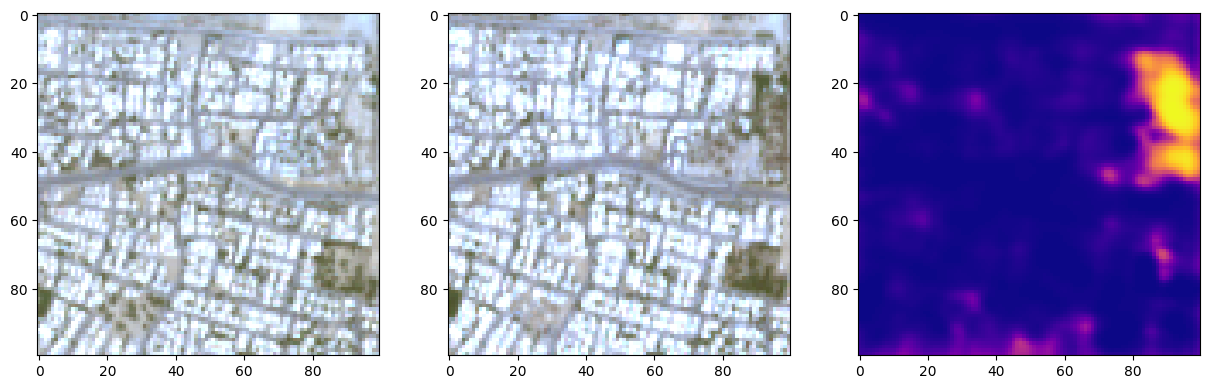

In [291]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.imshow(chip[..., [3, 2, 1]])
ax2.imshow(chip[..., [16, 15, 14]])
ax3.imshow(out[0, 1], cmap='plasma')
# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
plt.show()

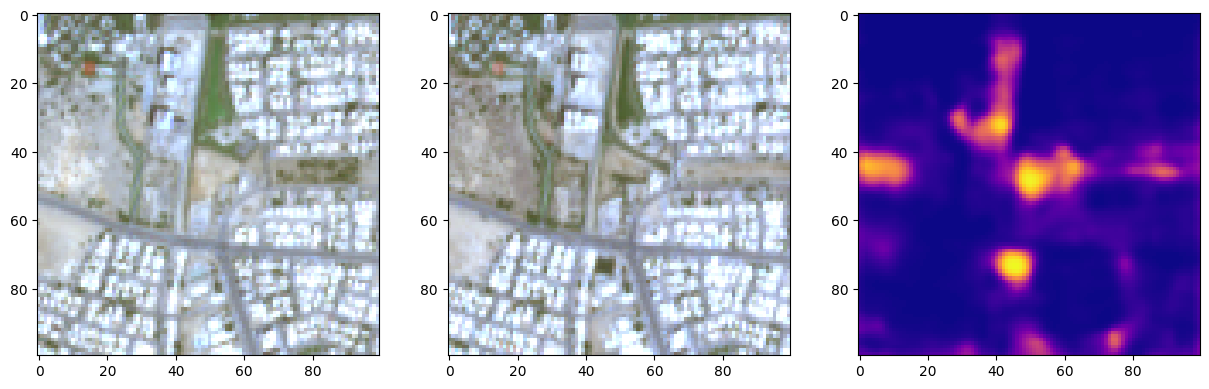

In [333]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.imshow(chip[..., [3, 2, 1]])
ax2.imshow(chip[..., [16, 15, 14]])
ax3.imshow(out[0, 1], cmap='plasma')
# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
plt.show()

---

In [229]:
stats_path_ss = 's3://raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/analyze/stats/train_scenes/stats.json'
stats_tf_ss = StatsTransformer.from_stats_json(stats_path_ss)
stats_tf_ss

StatsTransformer(means=array([422.50543924, 590.79170049, 446.01215719]), std=array([219.20605529, 240.83472561, 146.57817311]), max_stds=3.0)

In [307]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

bundle_uri = 's3://raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/train/model-bundle.zip'
learner = SemanticSegmentationLearner.from_model_bundle(bundle_uri, training=False)

2023-09-26 20:49:13:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle s3://raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/train/model-bundle.zip.
2023-09-26 20:49:13:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/train/model-bundle.zip.
2023-09-26 20:49:13:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmpjekmczao/model-bundle
2023-09-26 20:49:14:rastervision.pytorch_learner.learner: INFO - Local output dir: /opt/data/tmp/tmpjekmczao/s3/raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/train
2023-09-26 20:49:14:rastervision.pytorch_learner.learner: INFO - Remote output dir: s3://raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/train
2023-09-26 20:49:15:rastervision.pytorch_learner.learner: INFO - Loading model weights from: /opt/data/tmp/tmpjekmczao/model-bundle/model.pth


In [308]:
raster_source_ss = XarraySource(
    data_array.isel(band=[3, 2, 1], time=np.where(t_strs == '2023-09-12')[0].squeeze()),
    crs_transformer=crs_transformer,
    raster_transformers=[StatsTransformer(means=stats_tf_cd.means[[3, 2, 1]], stds=stats_tf_cd.stds[[3, 2, 1]])],
)
raster_source_ss.shape

(10980, 10980, 3)

In [309]:
window = Box(ymin=8900, xmin=4150, ymax=9225, xmax=4475)
window.extent

Box(ymin=0, xmin=0, ymax=325, xmax=325)

In [311]:
chip = raster_source_ss.get_chip(window)
chip.shape

(325, 325, 3)

In [312]:
tf = A.Resize(325, 325)

In [313]:
x = tf(image=chip)['image']
x = torch.from_numpy(x).float().permute(2, 0, 1).unsqueeze(0)
x /= 255
x.shape

torch.Size([1, 3, 325, 325])

In [314]:
out = learner.predict(x.cuda(), raw_out=True, out_shape=(325, 325)).cpu()
out.shape

torch.Size([1, 3, 325, 325])

In [315]:
out[0, 0].min(), out[0, 0].max()

(tensor(0.0001), tensor(0.0407))

In [305]:
out[0, 1].min(), out[0, 1].max()

(tensor(5.6641e-07), tensor(0.9898))

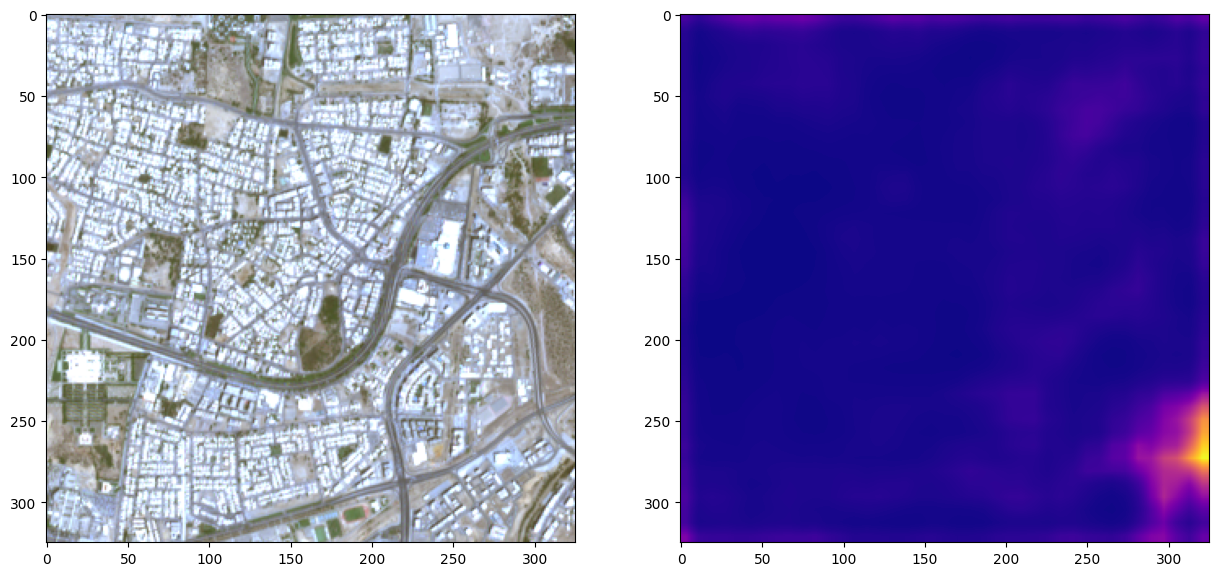

In [316]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(x[0].permute(1, 2, 0))
ax2.imshow(out[0, 0], cmap='plasma')
# ax1.axis('off')
# ax2.axis('off')
plt.show()

In [300]:
from rastervision.core.data.utils.rasterio import write_bbox

In [319]:
import pyproj

pyproj.CRS(stack.crs).to_wkt()

'PROJCRS["WGS 84 / UTM zone 40N",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["UTM zone 40N",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",57,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",500000,LENGTHUNIT["metre",1],ID["EPSG

In [320]:
write_bbox('test.tif', chip, bbox=crs_transformer.pixel_to_map(window), crs_wkt=pyproj.CRS(stack.crs).to_wkt())

In [327]:
%%sh
rastervision predict \
s3://raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/bundle/model-bundle.zip \
test.tif \
pred/

2023-09-26 21:26:13:rastervision.pipeline.file_system.utils: INFO - Downloading s3://raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/bundle/model-bundle.zip to /opt/data/tmp/cache/s3/raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/bundle/model-bundle.zip...
Downloading: 100%|██████████| 281M/281M [00:11<00:00, 25.4MB/s]
2023-09-26 21:26:26:rastervision.core.predictor: WARNING - Using stats for scene group "train_scenes". To use a different scene group, specify --scene-group <scene-group-name>.
2023-09-26 21:26:26:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle /opt/data/tmp/tmp7g0attei/bundle/model-bundle.zip.
2023-09-26 21:26:26:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to /opt/data/tmp/tmp7g0attei/model-bundle
2023-09-26 21:26:27:rastervision.pytorch_learner.learner: INFO - Local output dir: /opt/data/tmp/tmp7g0attei/s3/raster-vision/examples/0.21.2/output/spacenet-vegas-roads-ss/train
2023-09-26 21:26:27:ra